In [1]:
from datasets import load_dataset
from datasets import Dataset, DatasetDict, concatenate_datasets, Value, Features
import re
import matplotlib.pyplot as plt
import json
from pathlib import Path

/NL/strategic-compute/work/svenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [27]:
ds = load_dataset("Idavidrein/gpqa", "gpqa_extended")

In [34]:
import unicodedata
import re

def clean_text(s: str) -> str:
    # s = unicodedata.normalize("NFKC", s)
    # s = s.replace("\u2028", "").replace("\u2029", "").replace("\ufeff", "")
    # s = re.sub(r"[\x00-\x1f\x7f]", "", s)
    return s

In [35]:
import random

INSTR = (
    "Answer the following multiple choice question. The last line of your response should be of the following format: "
    "'Answer: $LETTER' (without quotes) where LETTER is one of ABCD. Think step by step before answering.\n\n"
)

def gpqa_to_jsonl(gpqa_dd: DatasetDict, out_path: str, seed: int = 0):
    ds = gpqa_dd["train"]
    rng = random.Random(seed)

    out_path = Path(out_path)
    out_path.parent.mkdir(parents=True, exist_ok=True)

    with out_path.open("w", encoding="utf-8") as f:
        for i, row in enumerate(ds):
            q = row["Question"]
            q = clean_text(q)
            correct = clean_text(row["Correct Answer"])
            incorrects = [
                clean_text(row["Incorrect Answer 1"]),
                clean_text(row["Incorrect Answer 2"]),
                clean_text(row["Incorrect Answer 3"]),
            ]

            options = [correct] + incorrects
            rng.shuffle(options)

            letters = ["A", "B", "C", "D"]
            correct_letter = letters[options.index(correct)]

            prompt = (
                INSTR
                + f"{q}\n\n"
                + f"A) {options[0]}\n"
                + f"B) {options[1]}\n"
                + f"C) {options[2]}\n"
                + f"D) {options[3]}"
            )

            obj = {
                "id": f"gpqa-{i+1}",
                "question": prompt,
                "final": correct_letter,
            }
            f.write(json.dumps(obj, ensure_ascii=False) + "\n")

In [36]:
gpqa_to_jsonl(ds, "../datasets/GPQA/test.jsonl", seed=1234)

# Construct accuracy curves

In [2]:
import sys

sys.path.append("..")

from scripts.load_results import load_results
from strategic_ttc.verifiers.gpqa import parse_pred_from_explanation_gpqa
from scripts.accuracy_analysis import (
    plot_model_curves,
    plot_all_curves,
    plot_all_curves_delta,
    reasoning_accuracy_curve_second_custom,
    plot_reasoning_curve_2,
    compute_curves_for_model_fast
)

In [3]:
results = load_results("../final_runs/GPQA")
maj_mean, maj_std, rew_mean, rew_std = {}, {}, {}, {}
token_mean, token_std = {}, {}
thetas = {}

Processing file: Llama-3.2-1B--temp-0.6--samples-128--max-512.jsonl
Bad JSON at line 610: Expecting value: line 1 column 1 (char 0)
Offending line repr: 'rsed=\'C\'; truth=\'B\'", "parsed=\'D\'; truth=\'B\'", "parsed=\'B\'; truth=\'B\'", "parsed=\'C\'; truth=\'B\'", "parsed=\'D\'; truth=\'B\'", "no Answer: <LETTER> found; truth=\'B\'", "parsed=\'C\'; truth=\'B\'", "parsed=\'D\'; '
Processing file: Qwen2-0.5B--temp-0.7--samples-128--max-512.jsonl
Processing file: Llama-3.1-8B--temp-0.6--samples-128--max-512.jsonl
Processing file: Qwen2-7B--temp-0.7--samples-128--max-512.jsonl
Processing file: reason-R1-D-Qwen-7B--temp-0.6--samples-32--max-2048.jsonl
Processing file: reason-R1-D-Qwen-1.5B--temp-0.6--samples-32--max-2048.jsonl
Processing file: Llama-3-8B--temp-0.6--samples-128--max-512.jsonl
Processing file: reason-R1-D-Llama-8B--temp-0.6--samples-32--max-2048.jsonl
Processing file: Qwen2-1.5B--temp-0.7--samples-128--max-512.jsonl
Processing file: Llama-3.2-3B--temp-0.6--samples-128--max-

In [4]:
reasoning_models = [
    "reason-R1-D-Llama-8B--temp-0.6",
    "reason-R1-D-Qwen-1.5B--temp-0.6",
    "reason-R1-D-Qwen-7B--temp-0.6",
]

In [5]:
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "axes.titlesize": 10,
    "axes.labelsize": 9,
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "figure.dpi": 300,
    "axes.grid": True,
    "grid.alpha": 0.3,
    "grid.linestyle": "--"
})


Processing model: Llama-3.2-1B--temp-0.6


100%|██████████| 6/6 [00:00<00:00, 85.73it/s]


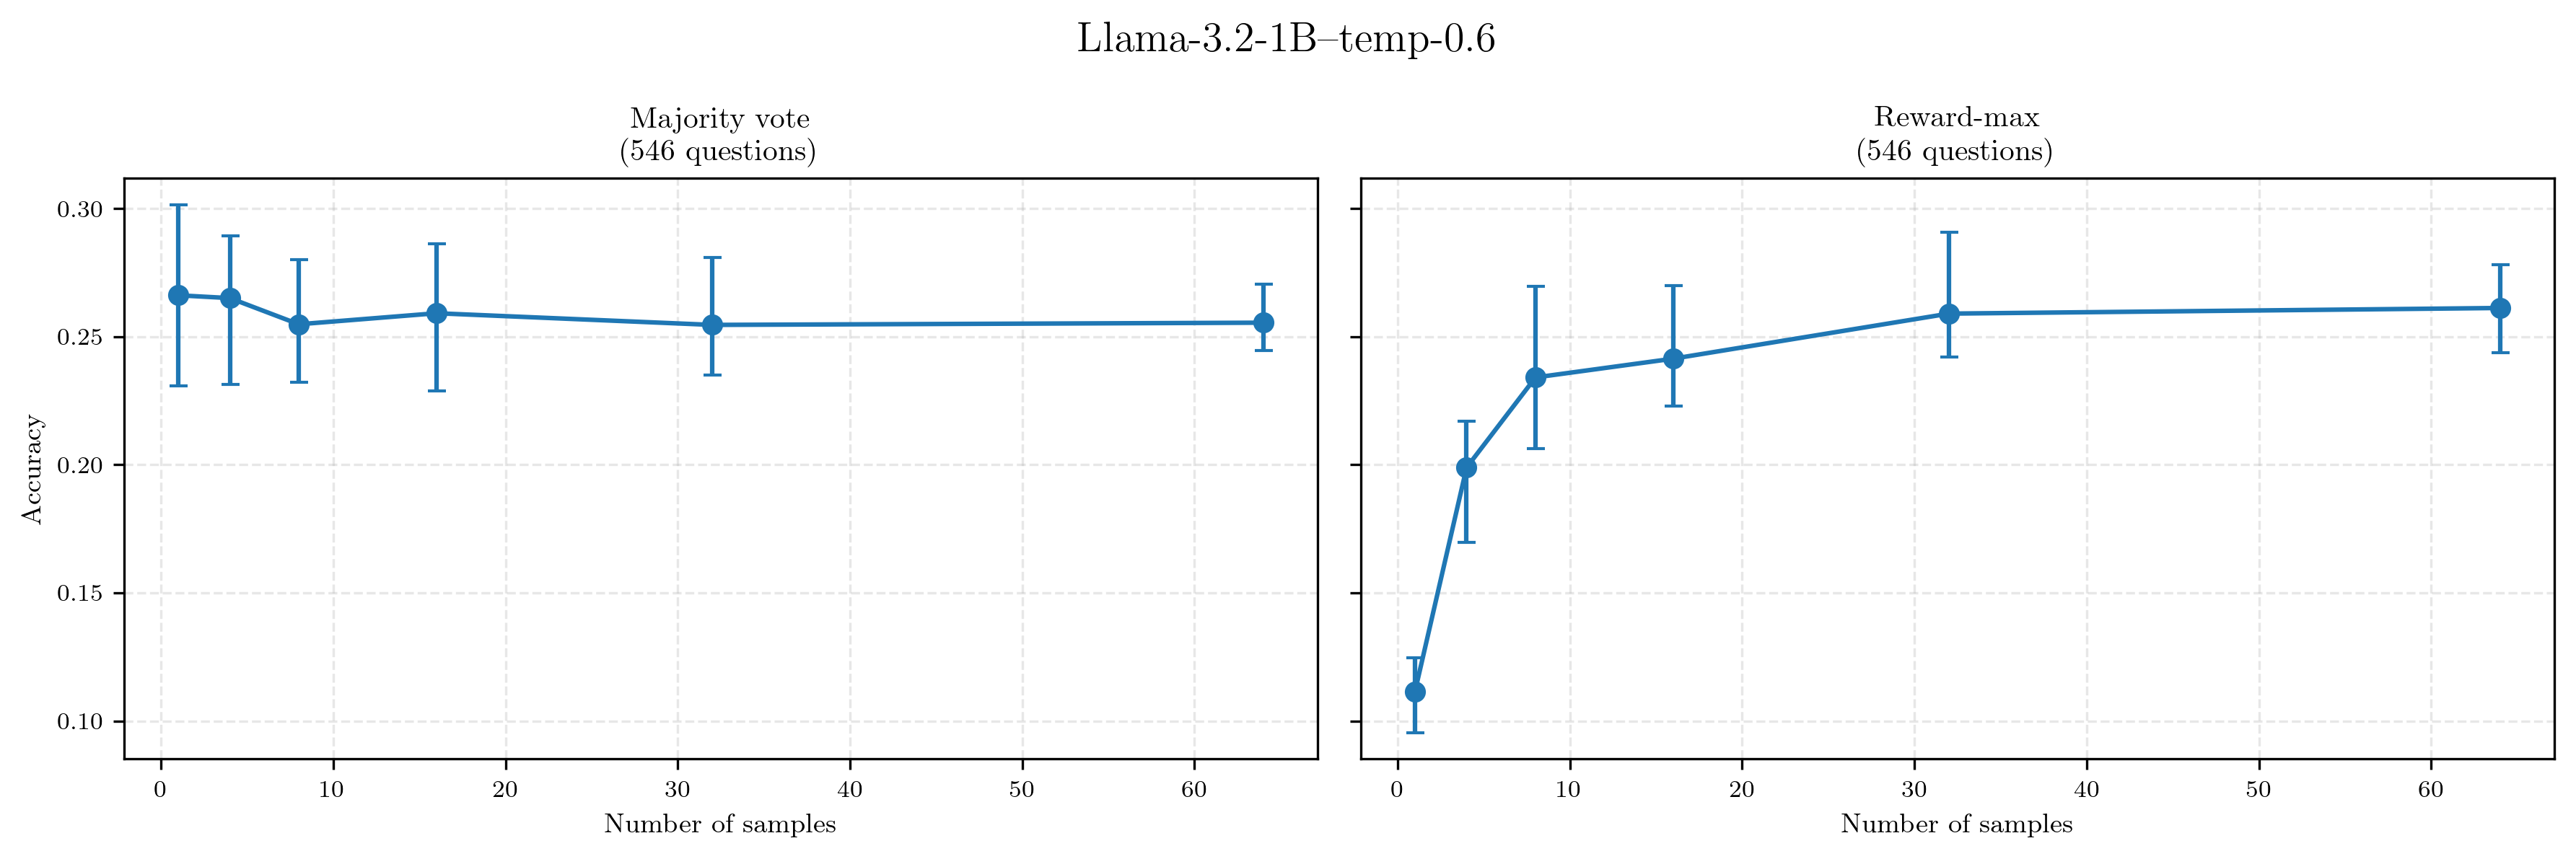

Processing model: Qwen2-0.5B--temp-0.7


100%|██████████| 6/6 [00:00<00:00, 93.43it/s]


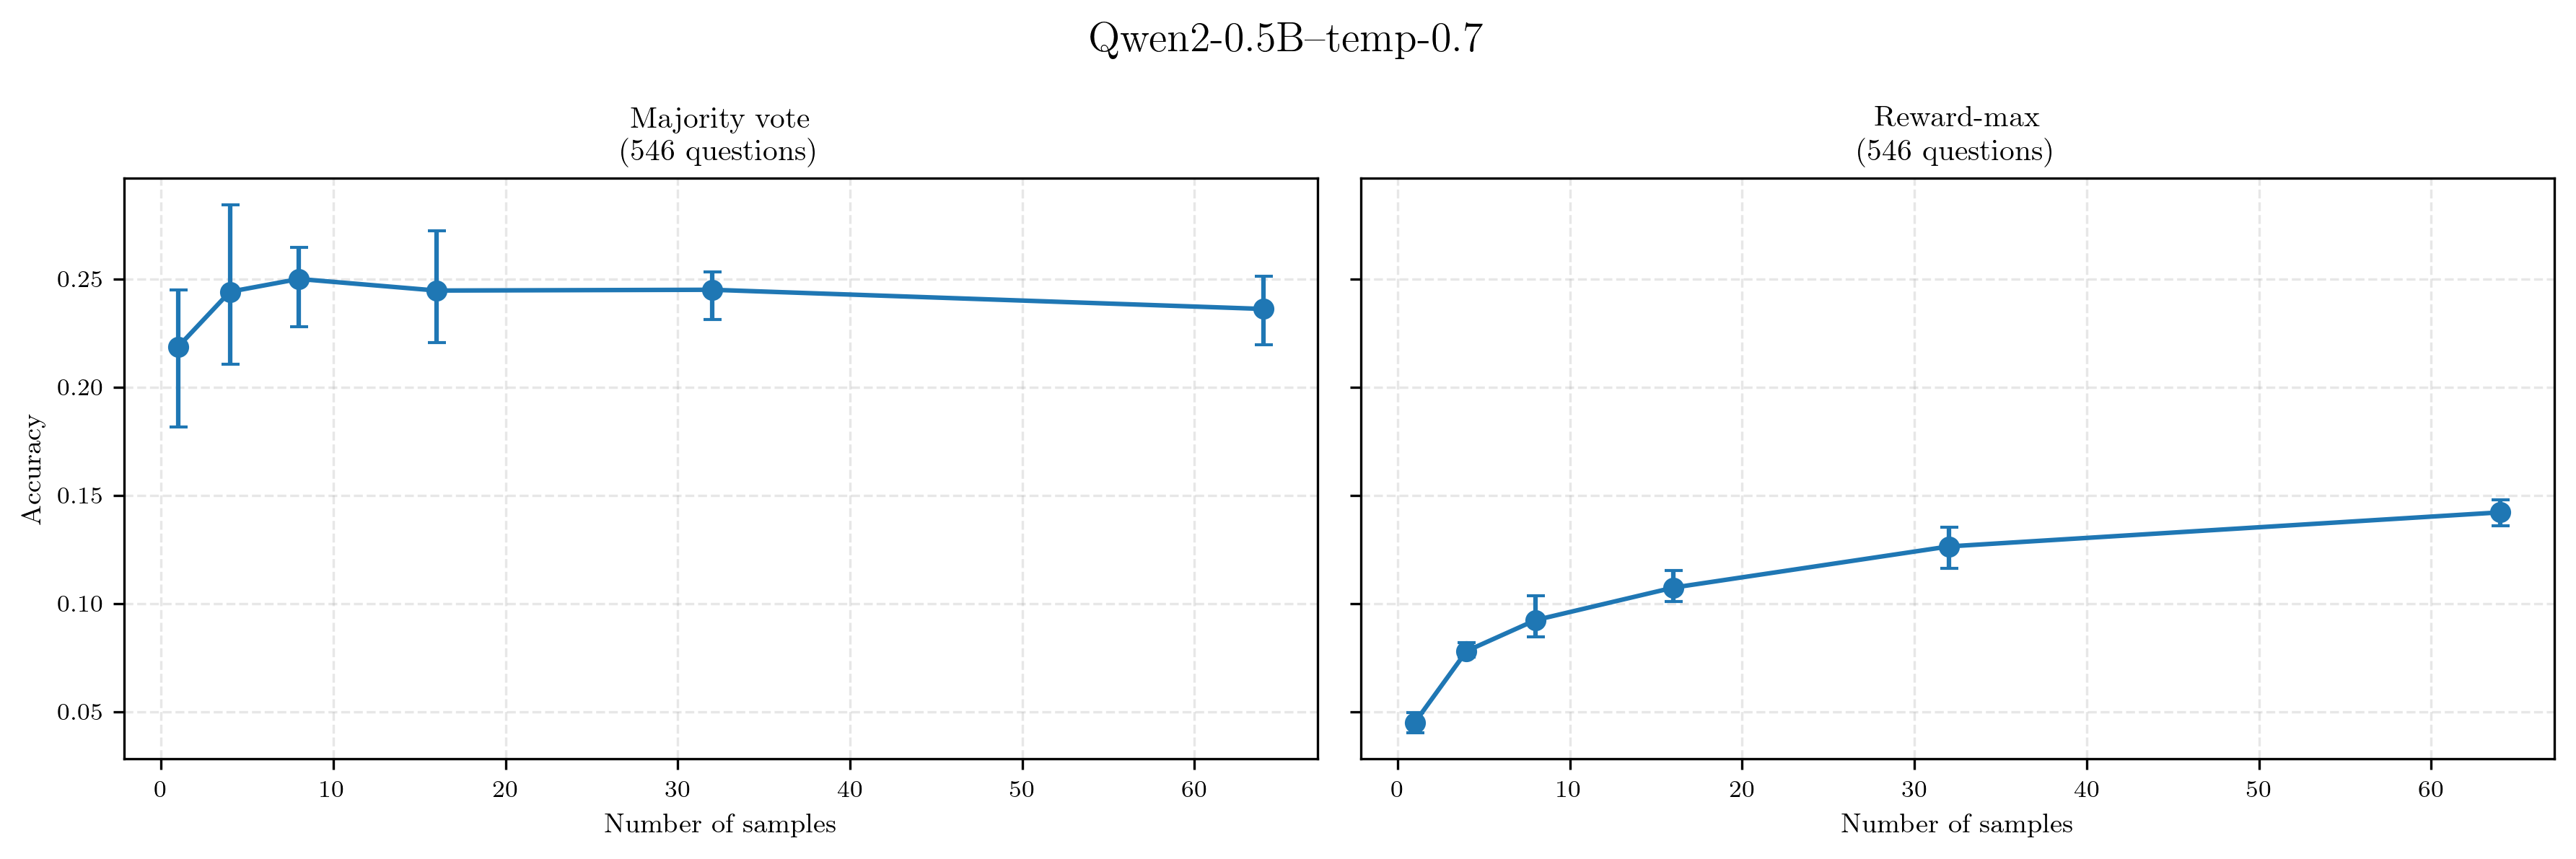

Processing model: Llama-3.1-8B--temp-0.6


100%|██████████| 6/6 [00:00<00:00, 99.00it/s]


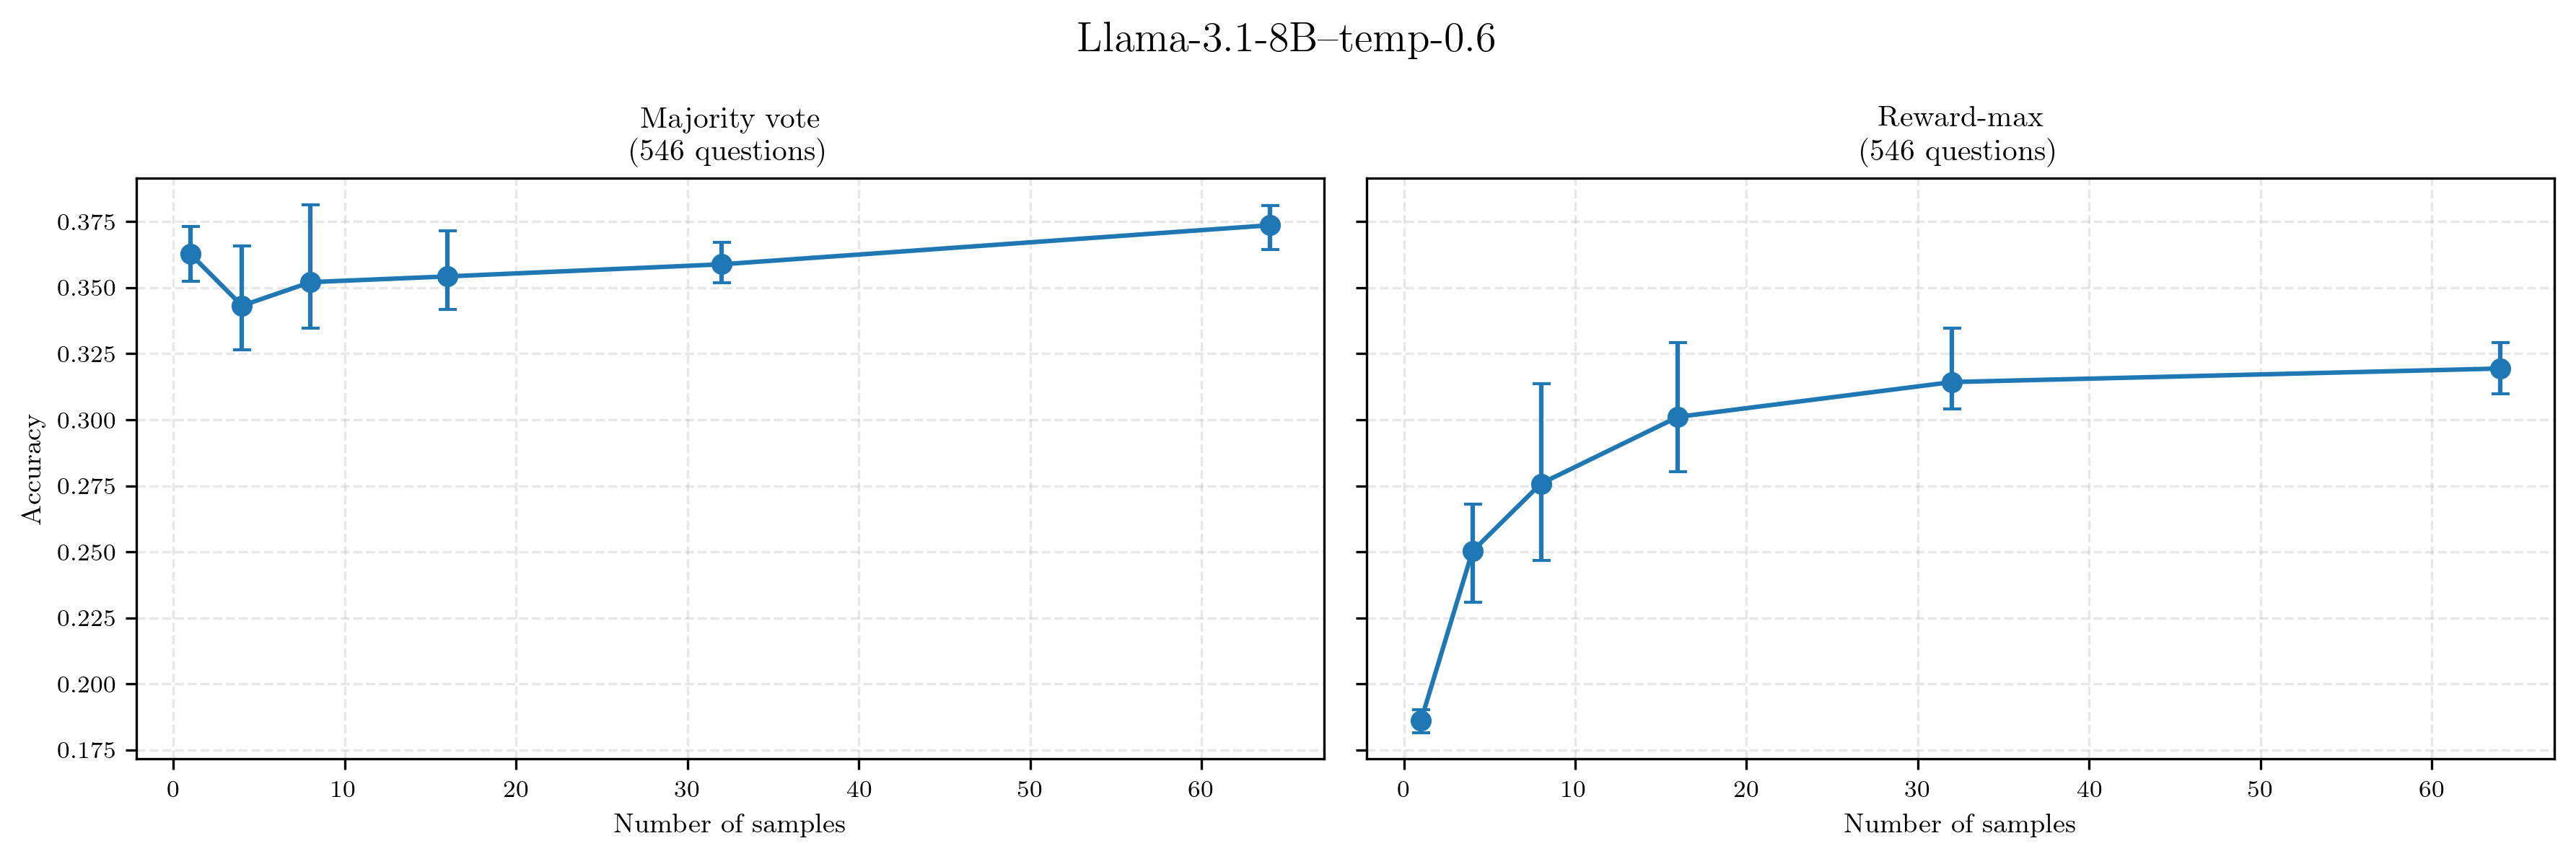

Processing model: Qwen2-7B--temp-0.7


100%|██████████| 6/6 [00:00<00:00, 103.90it/s]


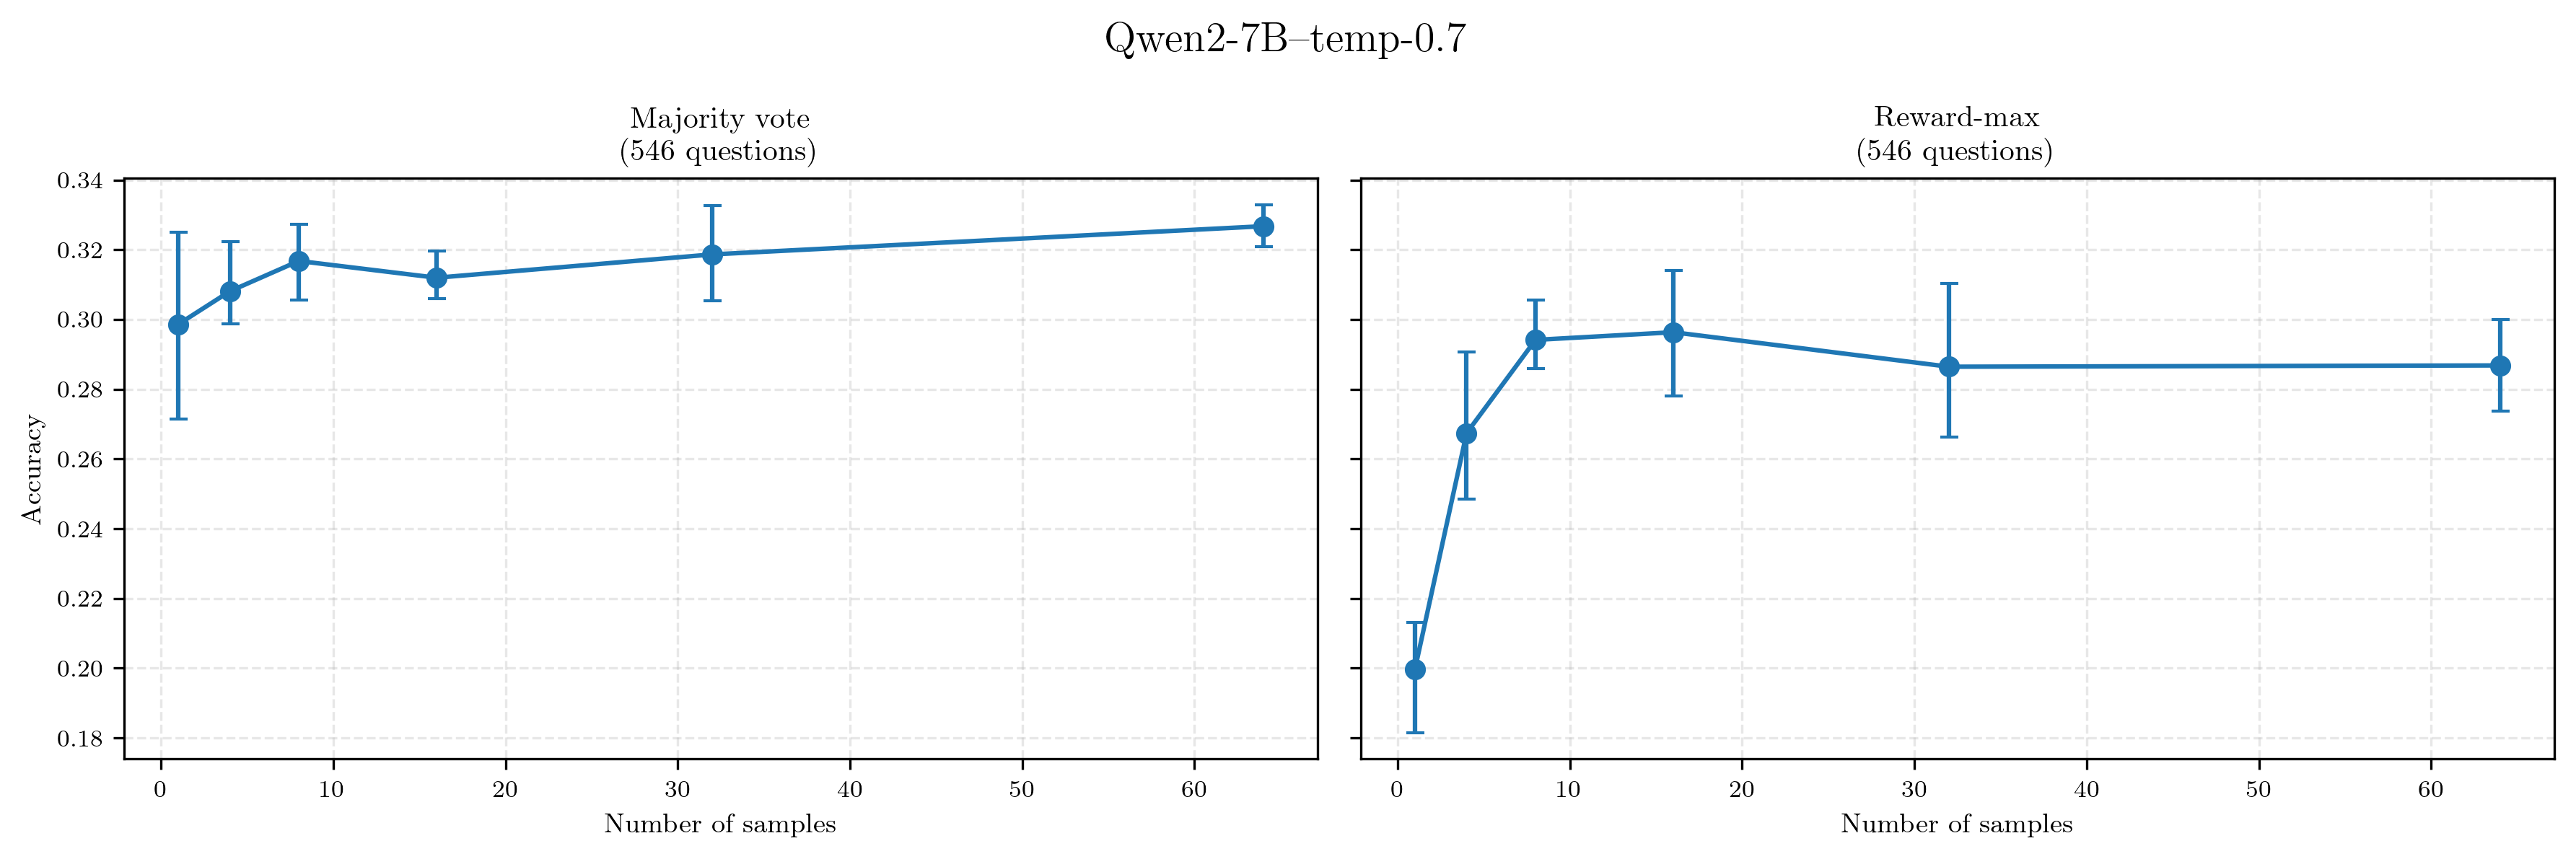

Processing model: Llama-3-8B--temp-0.6


100%|██████████| 6/6 [00:00<00:00, 105.80it/s]


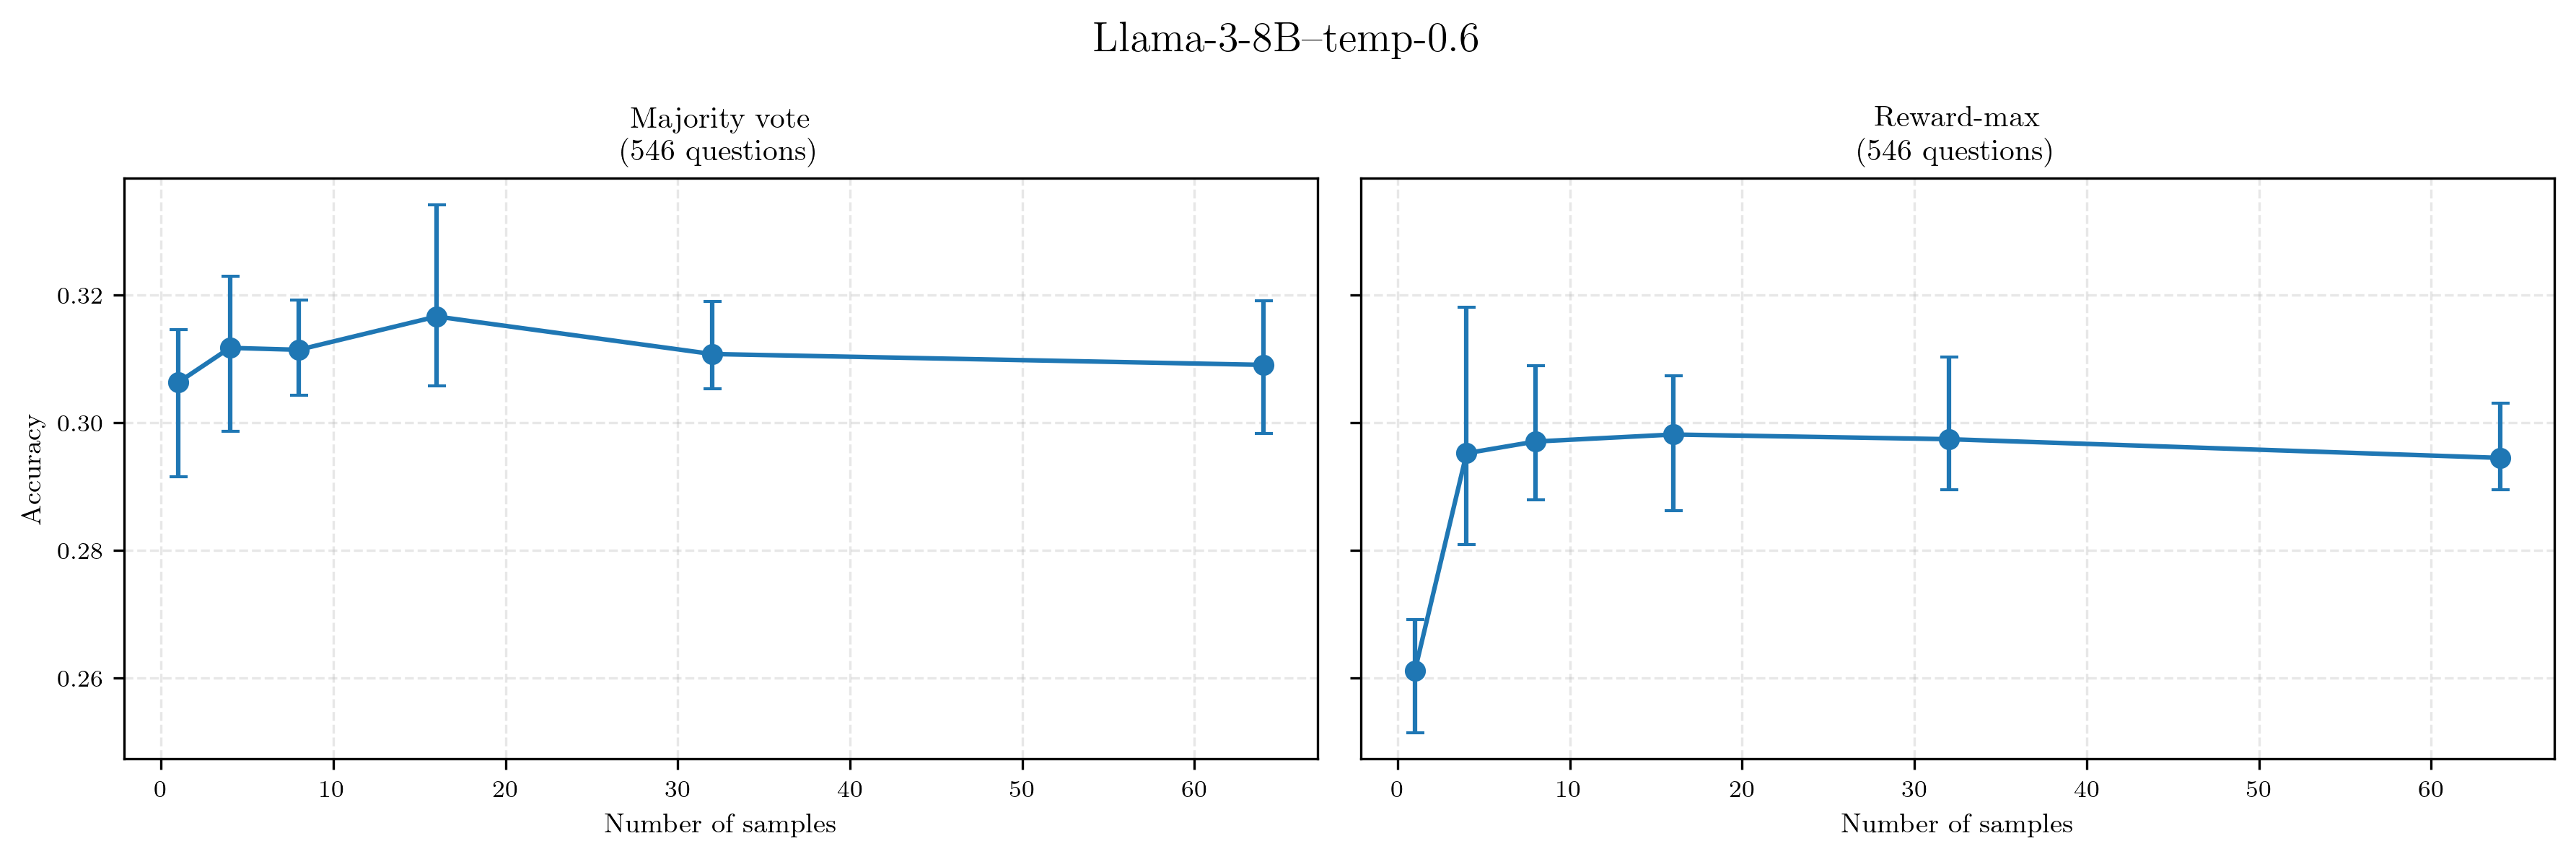

Processing model: Qwen2-1.5B--temp-0.7


100%|██████████| 6/6 [00:00<00:00, 101.94it/s]


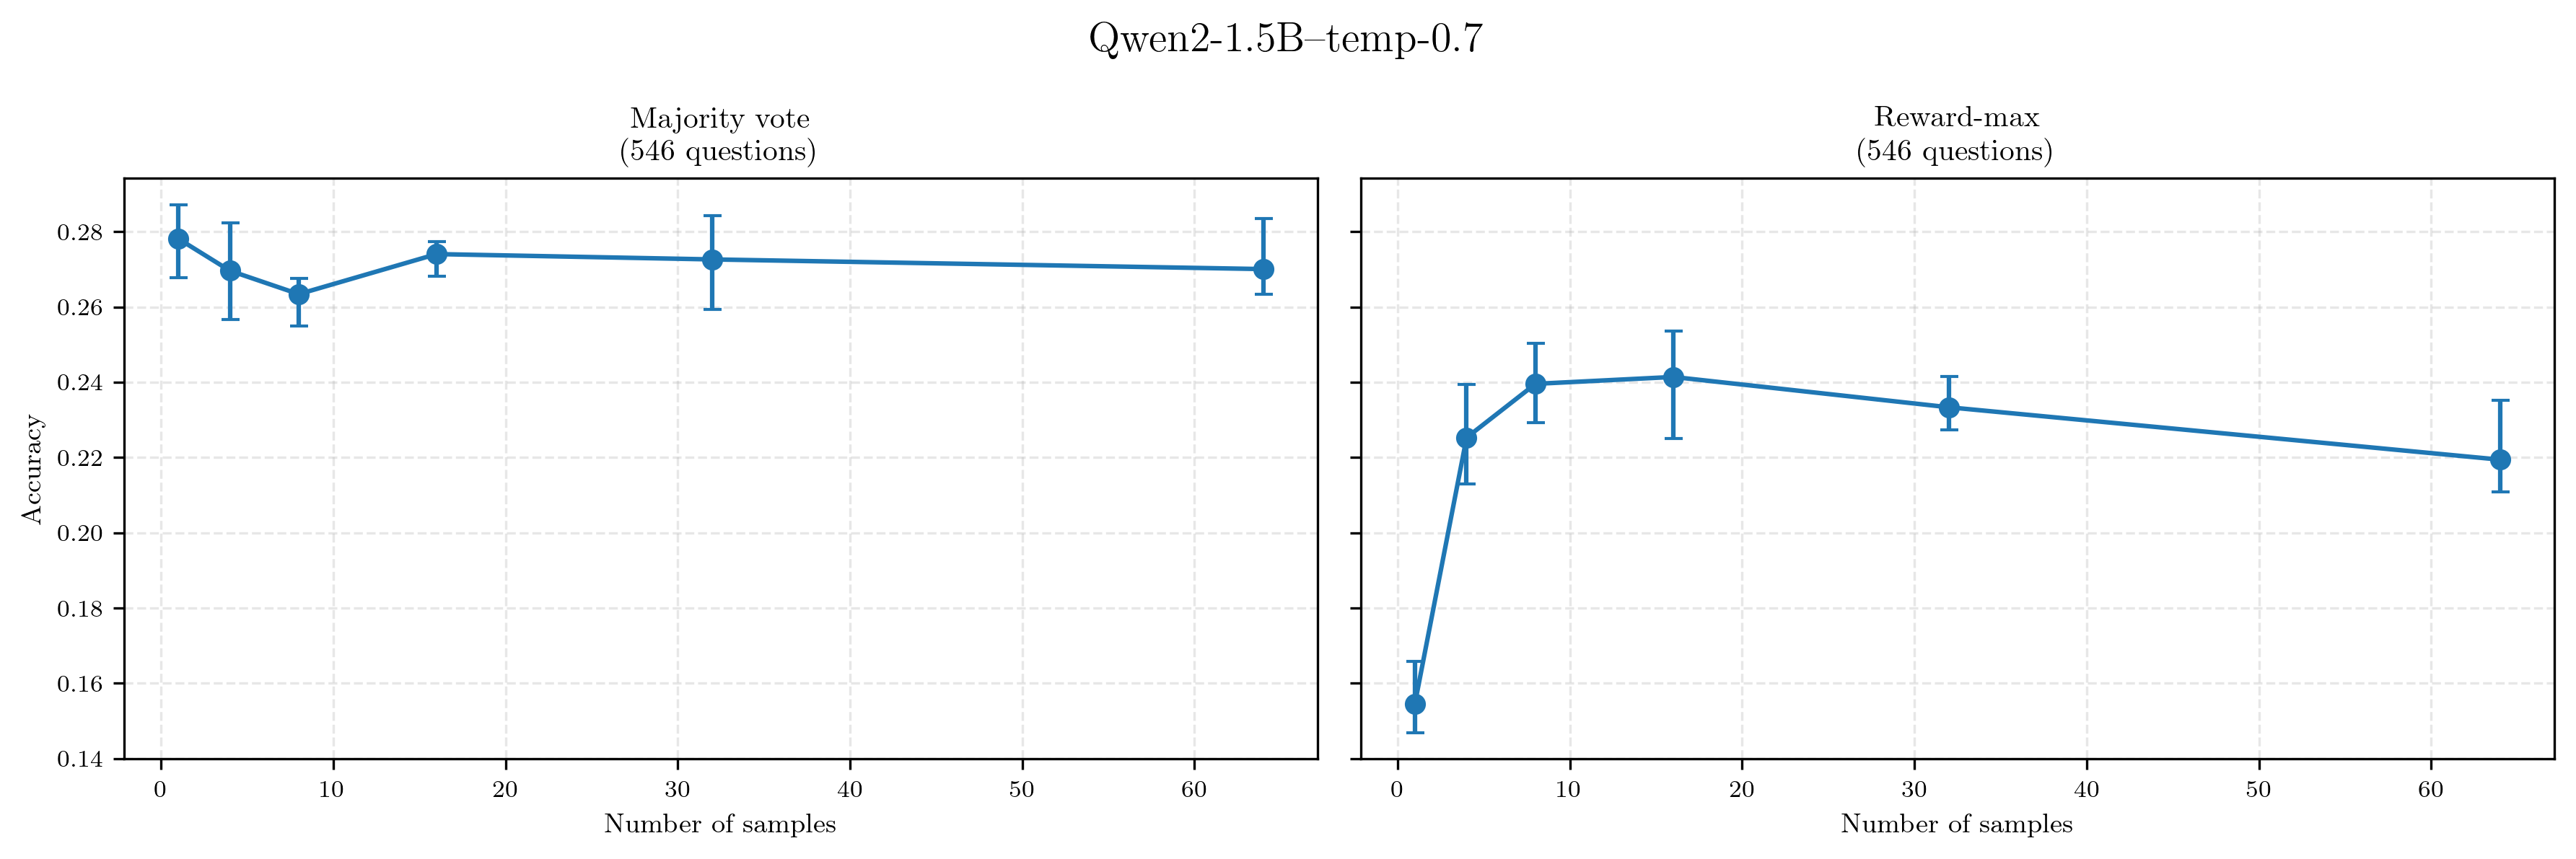

Processing model: Llama-3.2-3B--temp-0.6


100%|██████████| 6/6 [00:00<00:00, 104.79it/s]


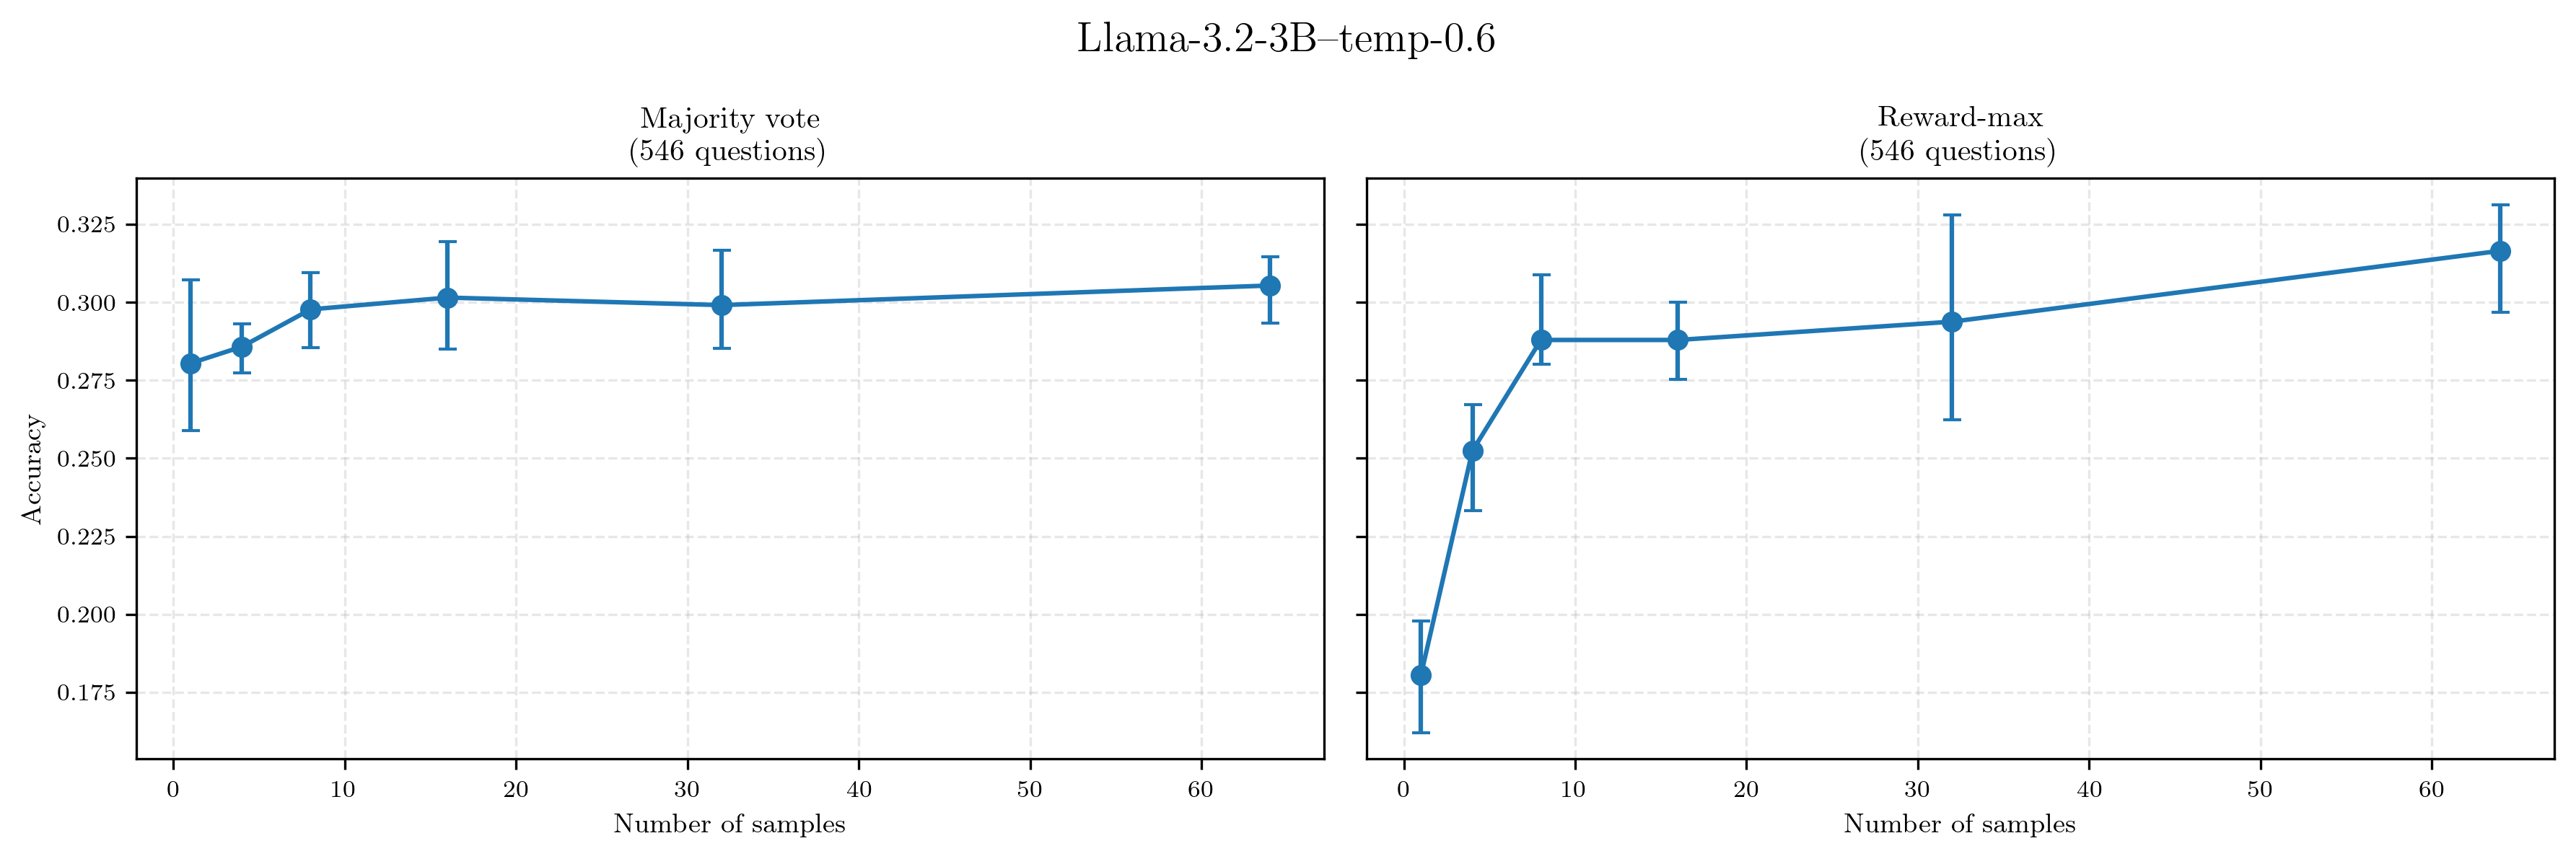

Processing model: Qwen2.5-7B--temp-0.7


100%|██████████| 6/6 [00:00<00:00, 105.57it/s]


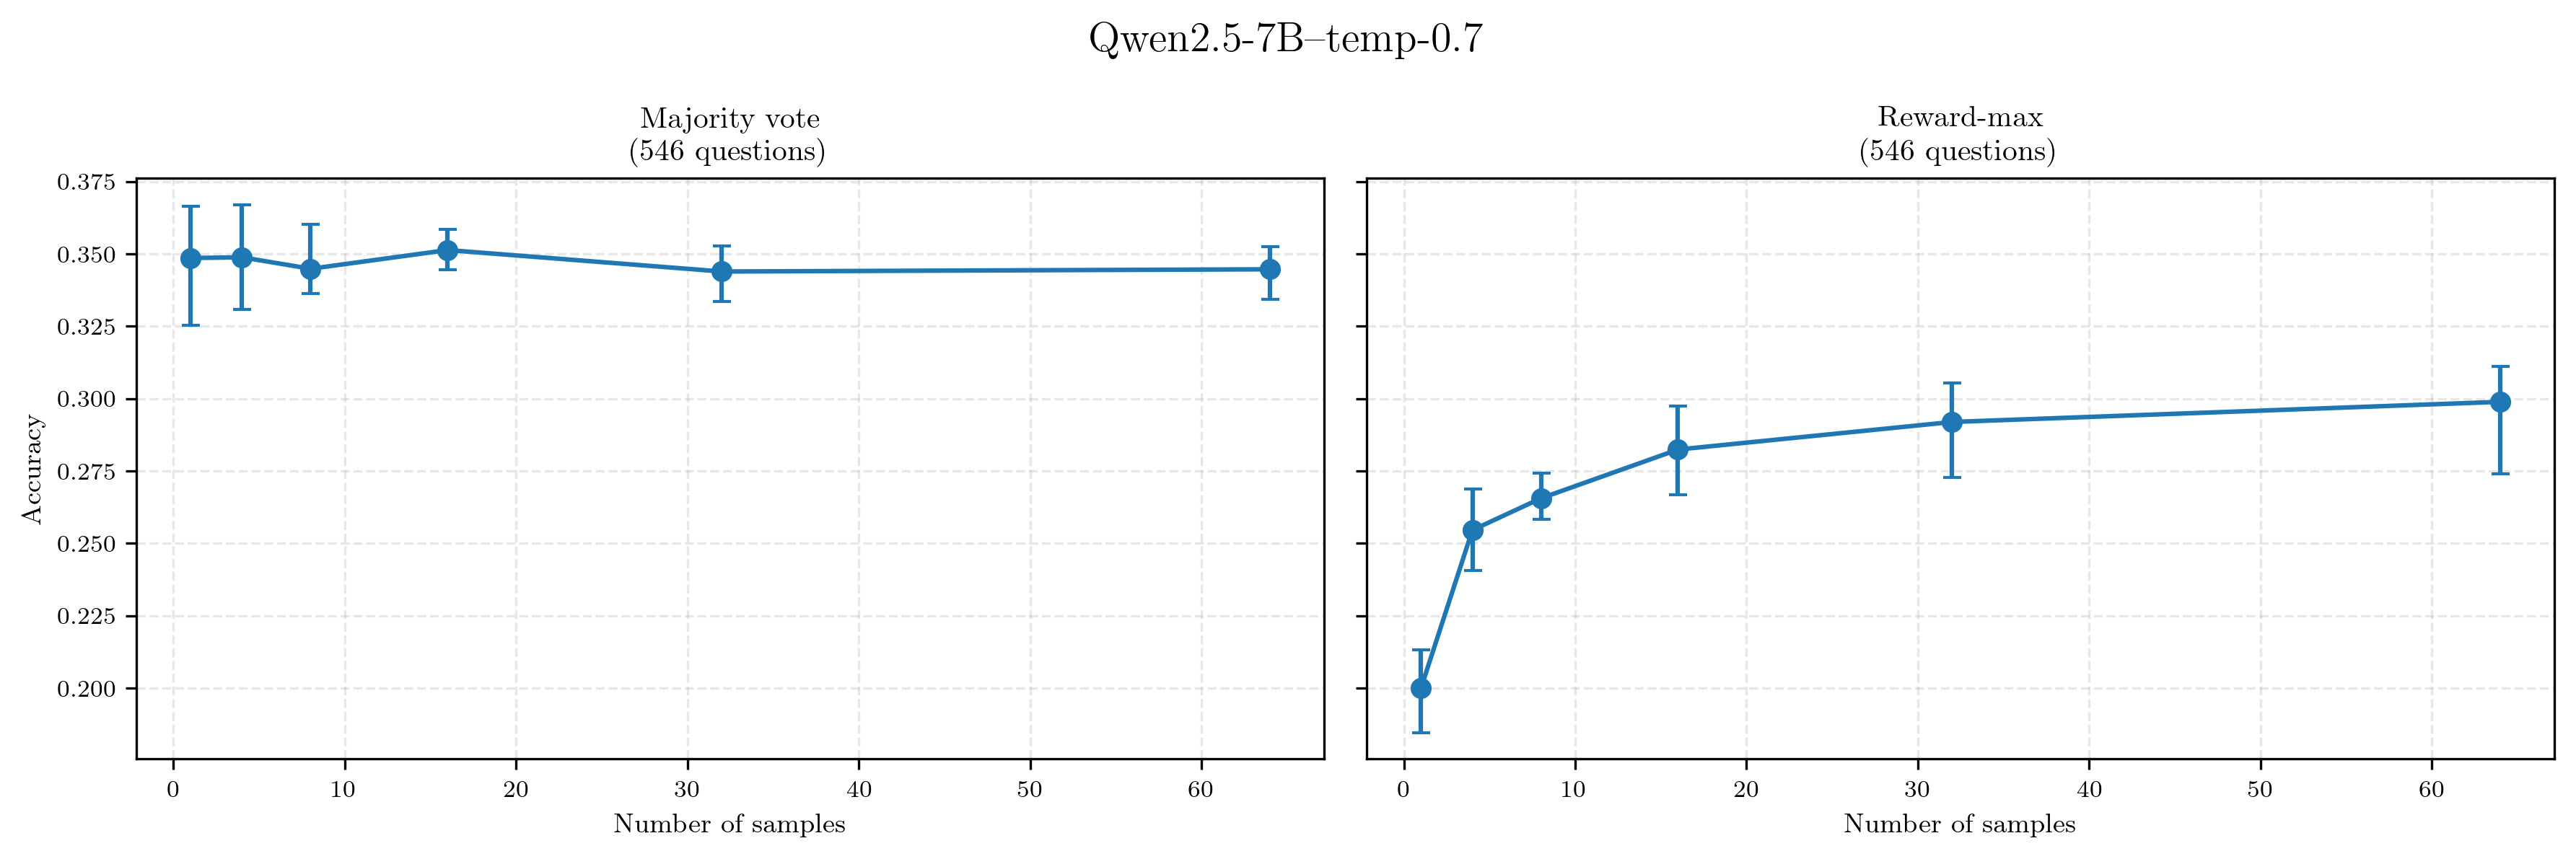

Processing model: Qwen2.5-3B--temp-0.7


100%|██████████| 6/6 [00:00<00:00, 121.21it/s]


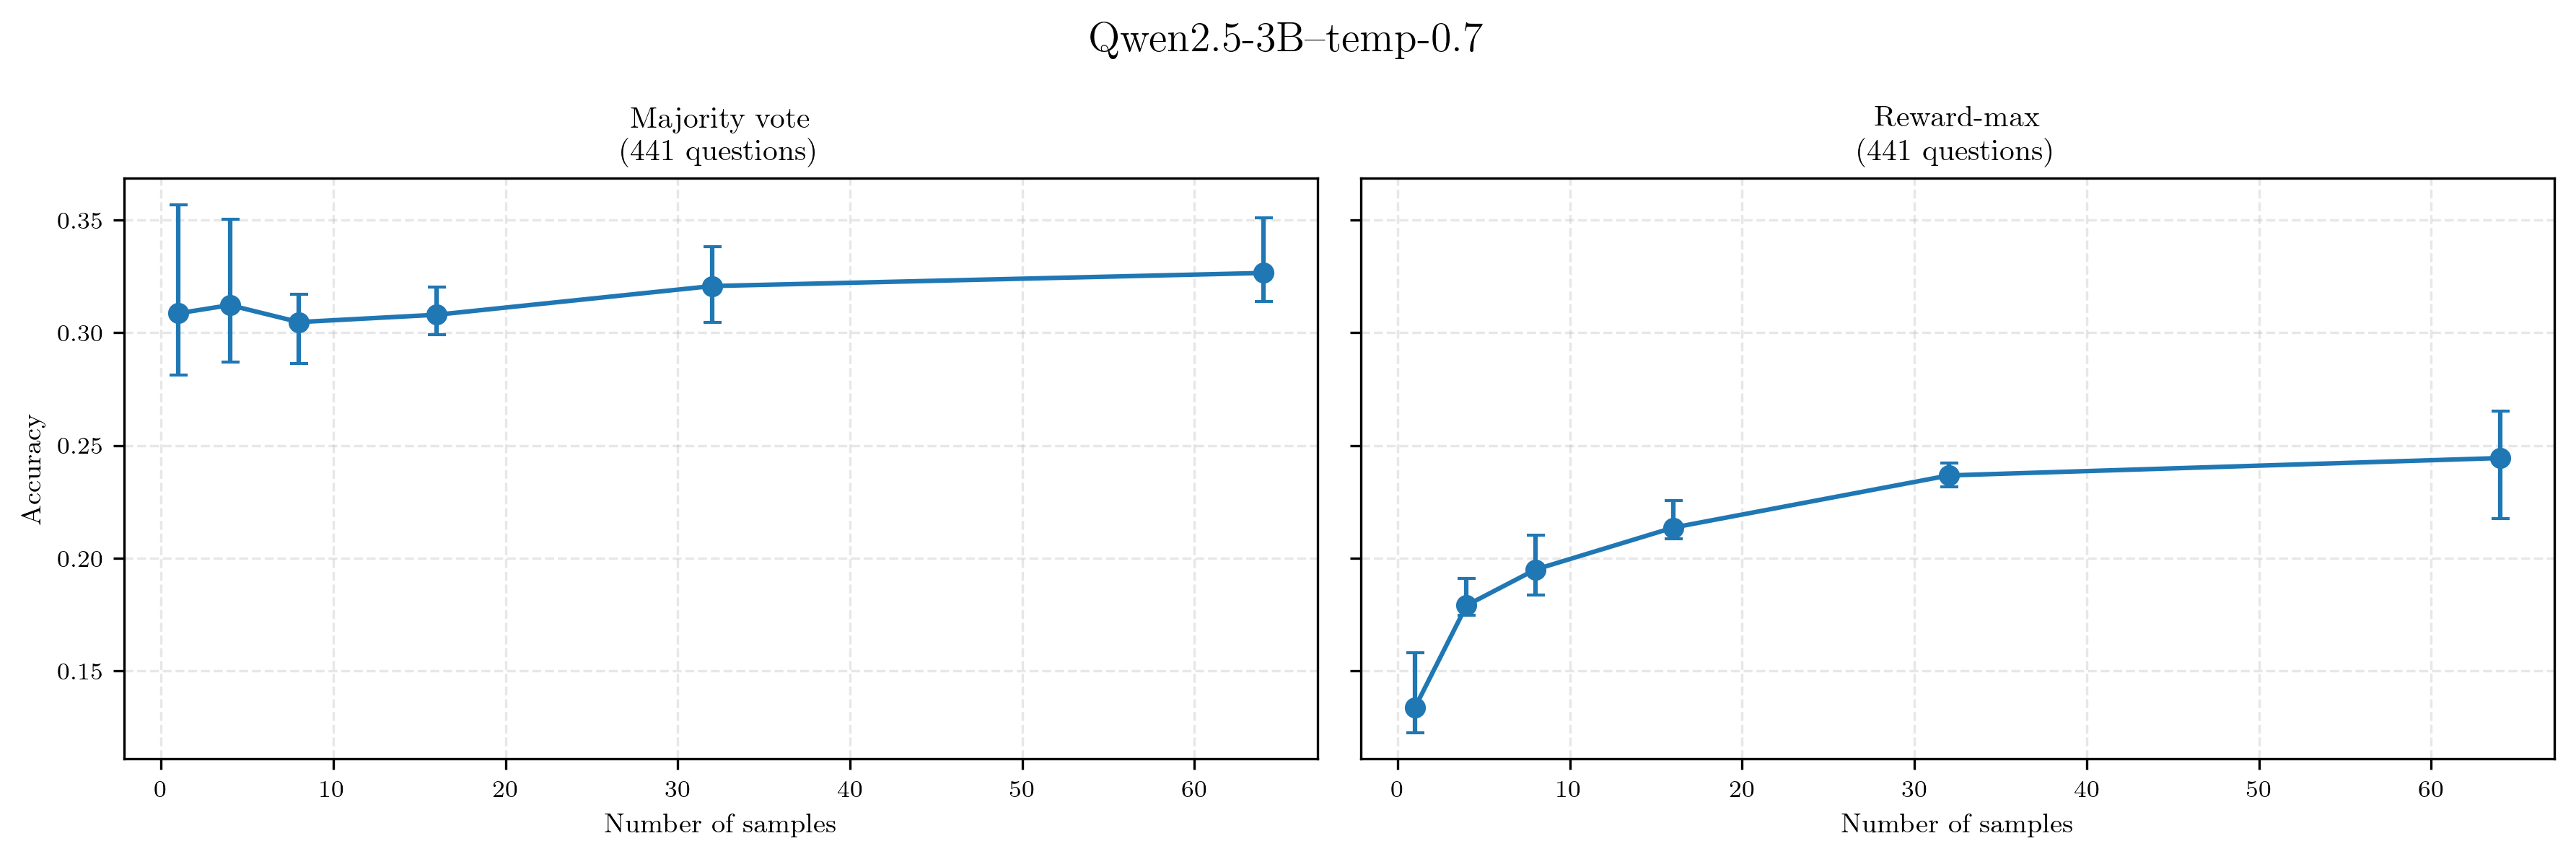

In [6]:
for model_name, data in results.items():
    if model_name in reasoning_models:
        continue
    print(f"Processing model: {model_name}")
    (
        thetas[model_name],
        maj_mean[model_name],
        maj_std[model_name],
        rew_mean[model_name],
        rew_std[model_name],
        token_mean[model_name],
        token_std[model_name],
    ) = compute_curves_for_model_fast(
        data,
        parse_pred_fn=parse_pred_from_explanation_gpqa,
        sample_size=5,
    )
    plot_model_curves(
        model_name,
        thetas[model_name],
        maj_mean[model_name],
        maj_std[model_name],
        rew_mean[model_name],
        rew_std[model_name],
        len(data["correct"]),
    )

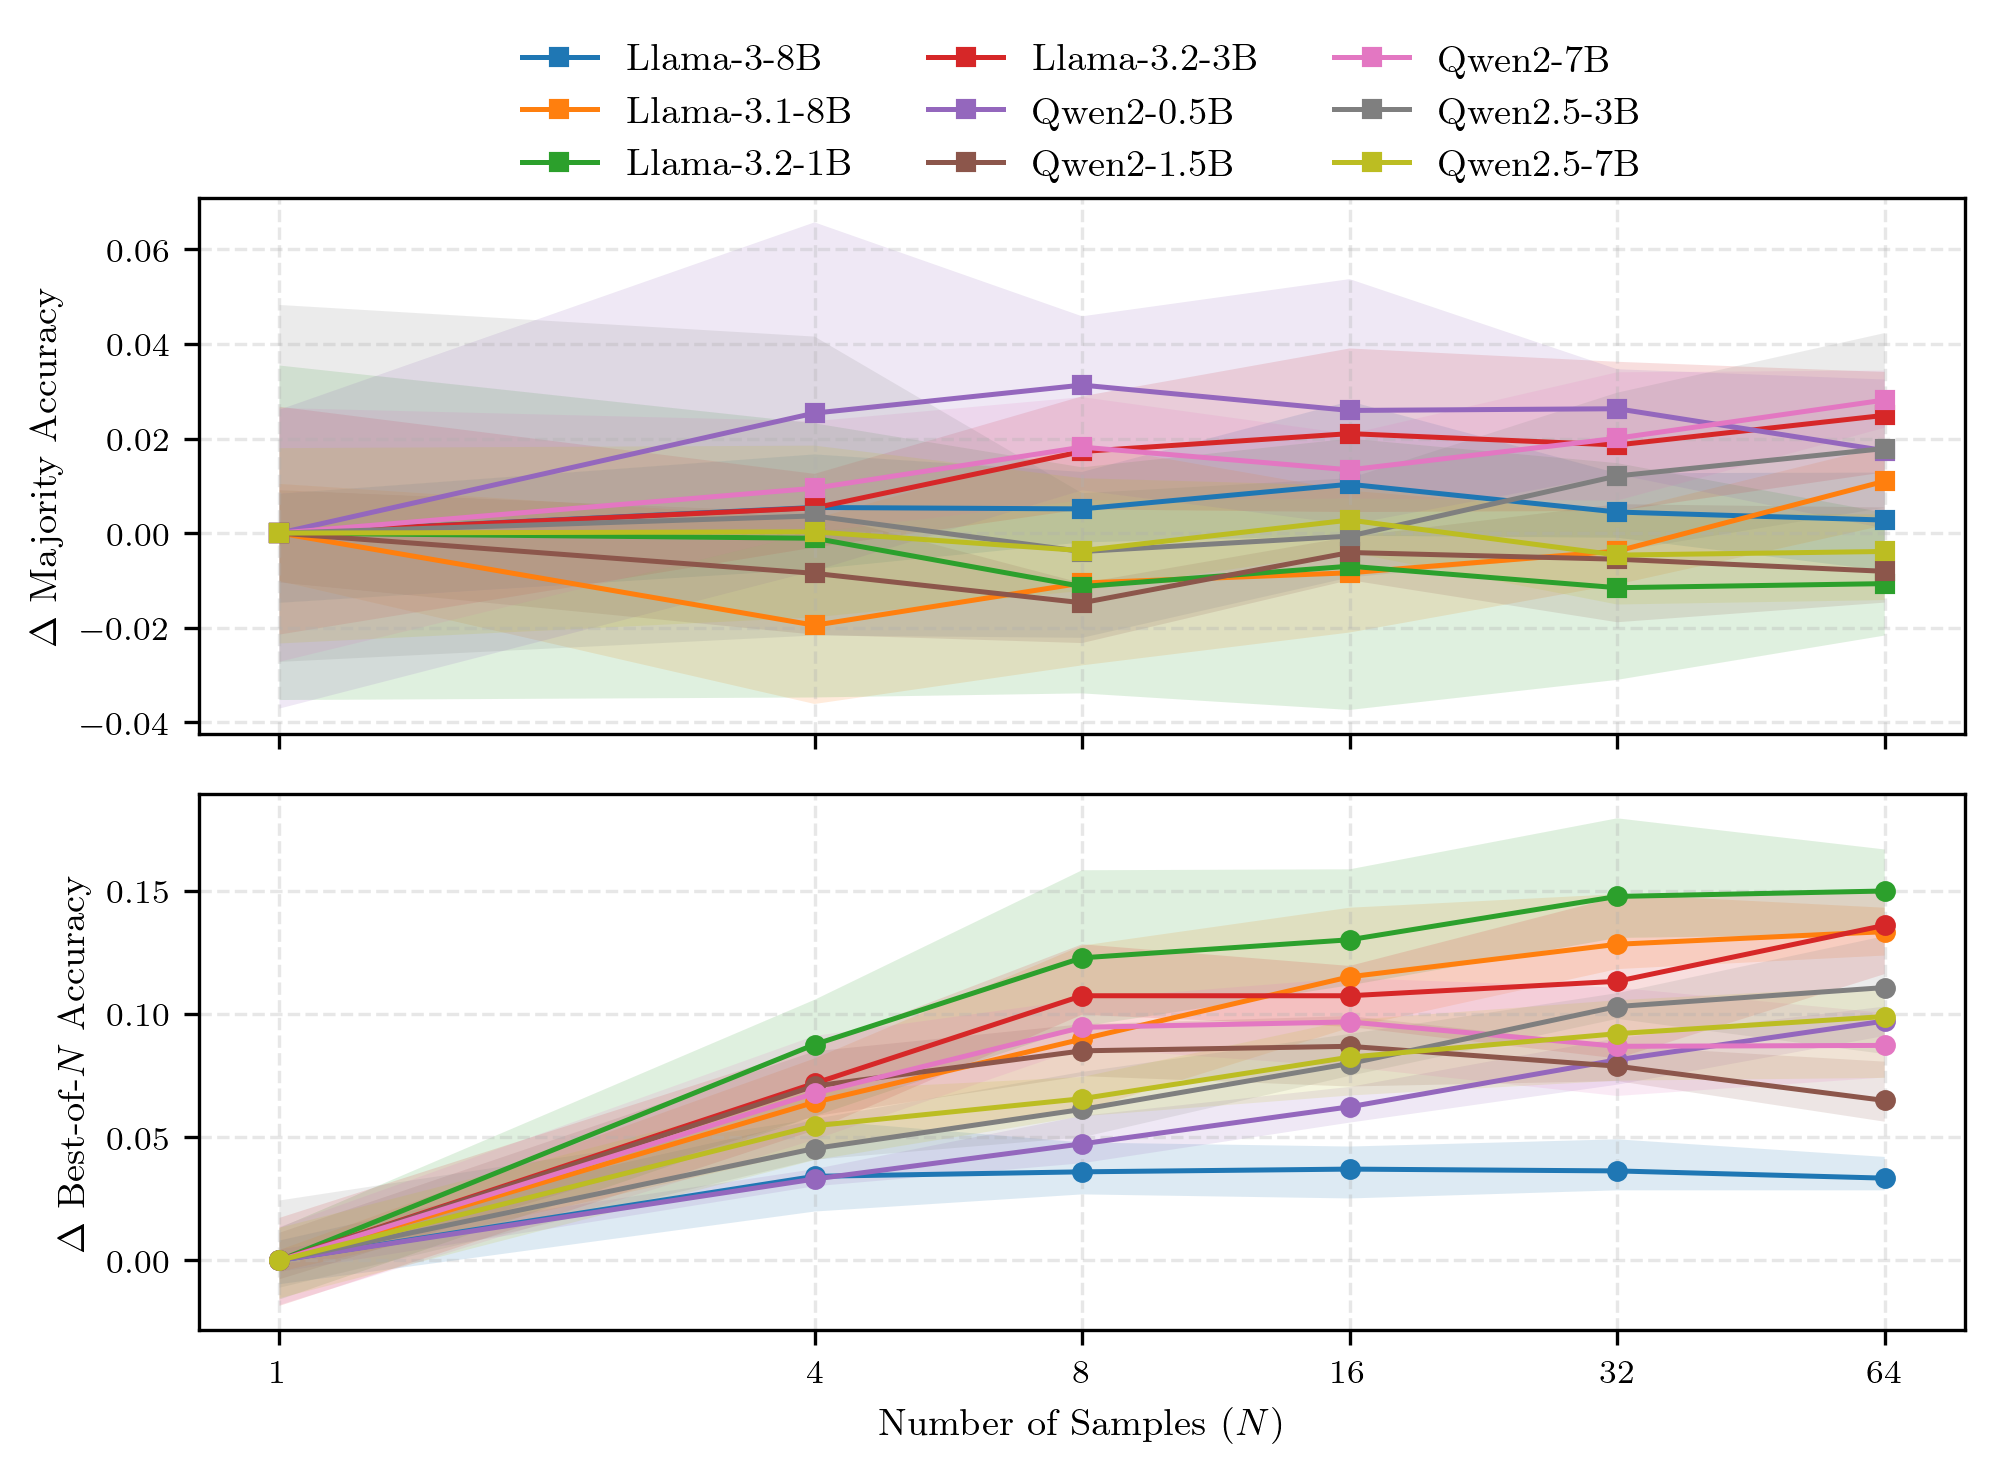

In [7]:
plot_all_curves_delta(
    thetas, maj_mean, maj_std, rew_mean, rew_std, filename="../figures/GSM8K/curves.pdf"
)

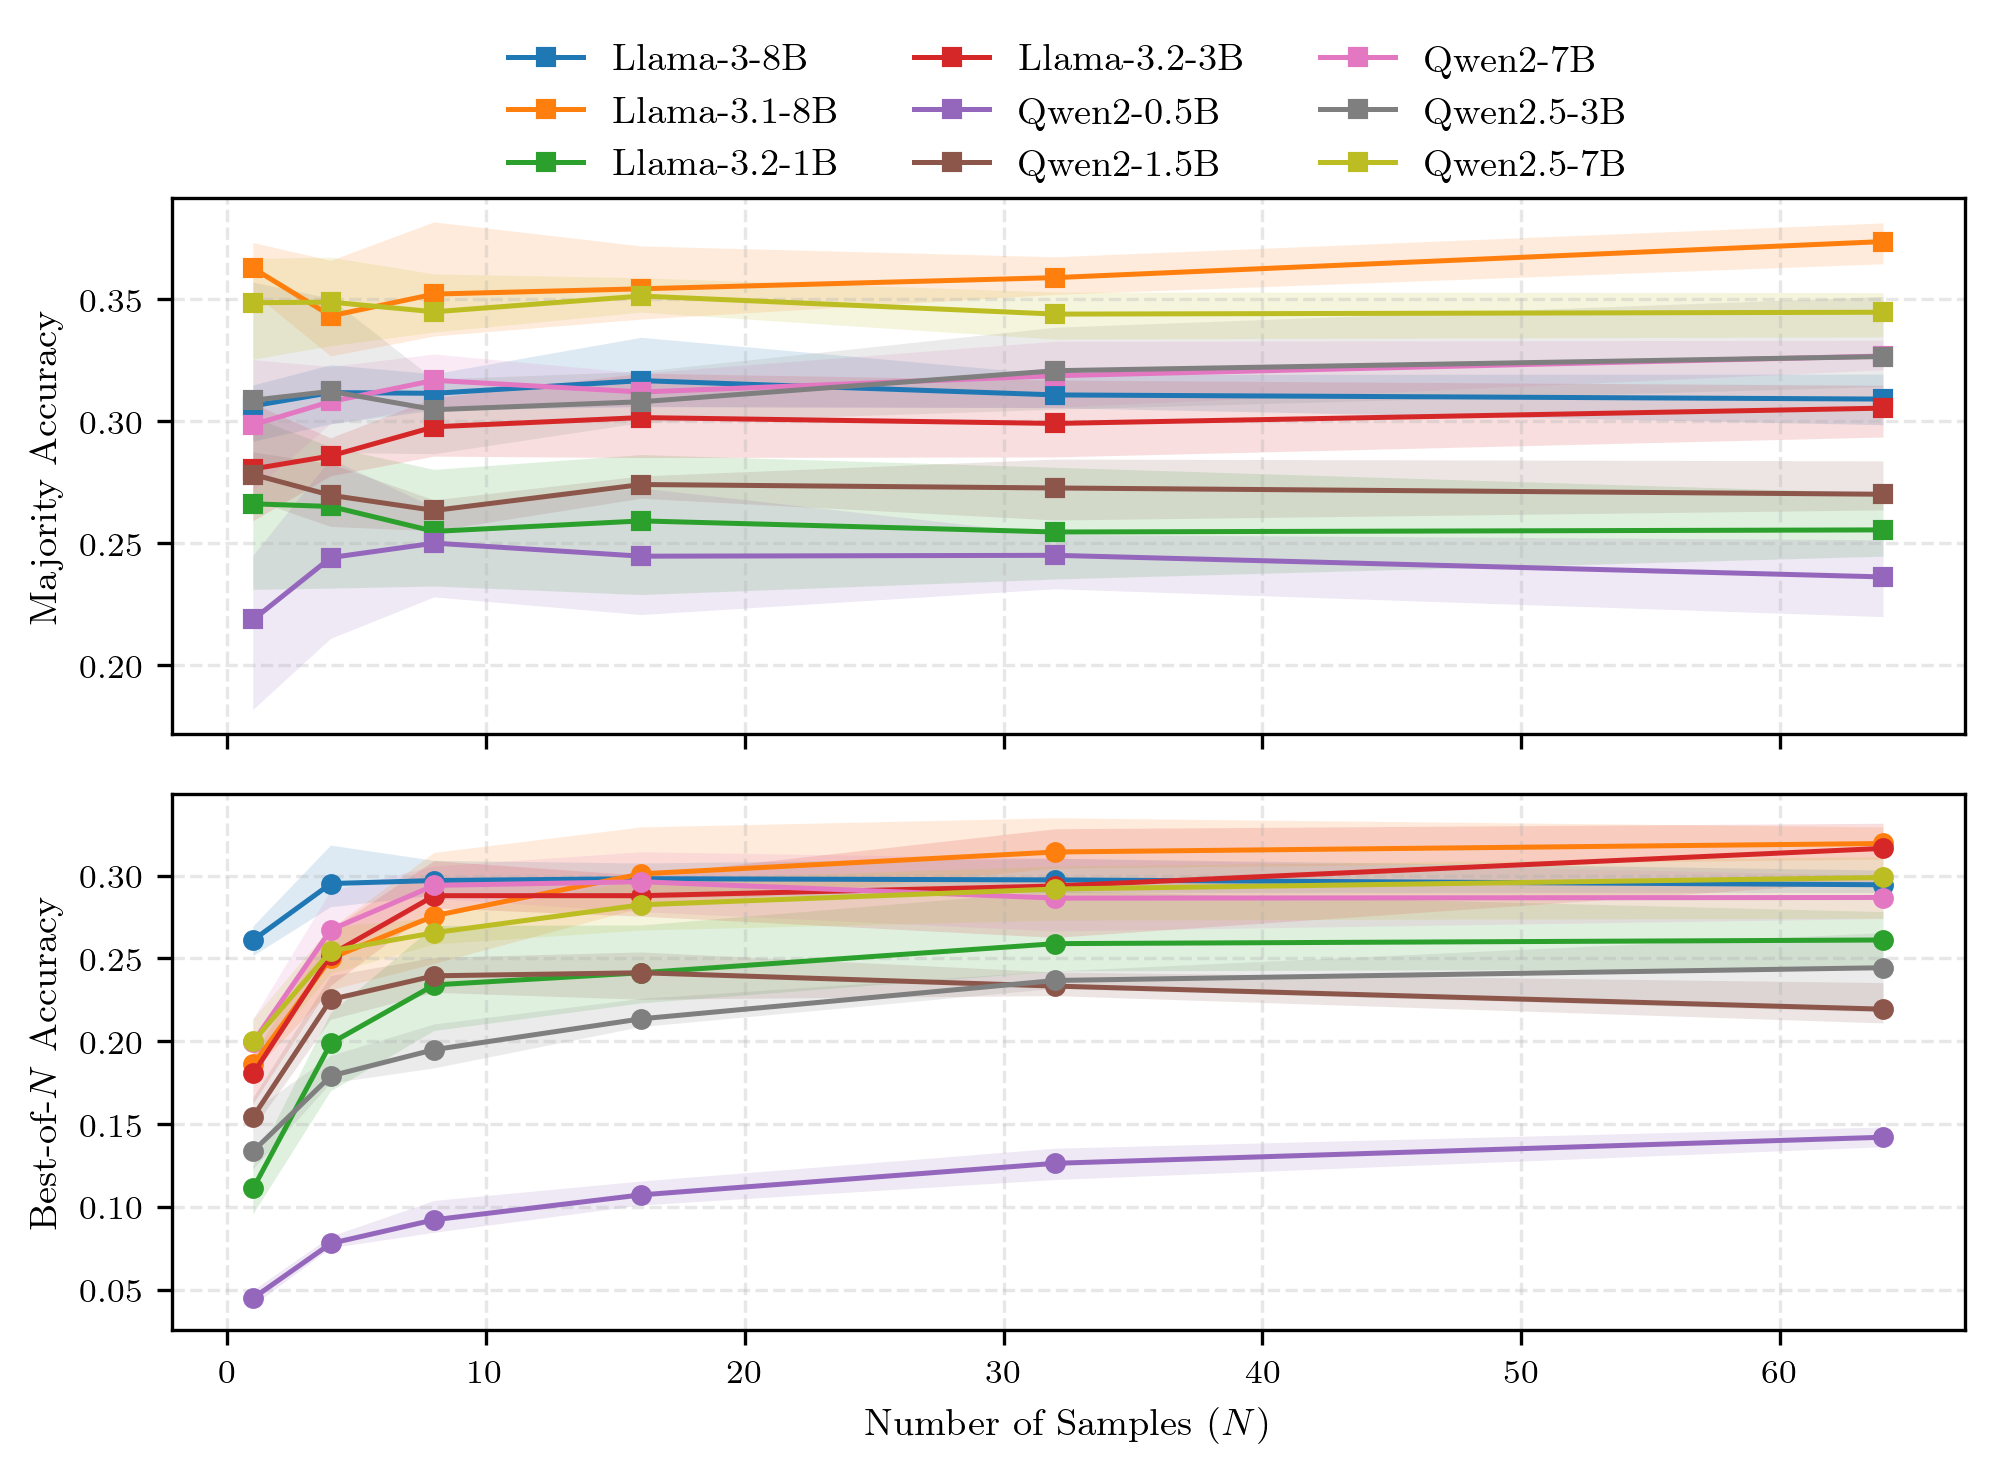

In [8]:
plot_all_curves(
    thetas,
    maj_mean,
    maj_std,
    rew_mean,
    rew_std,
    filename="../figures/GSM8K/curves_absolute.pdf",
)

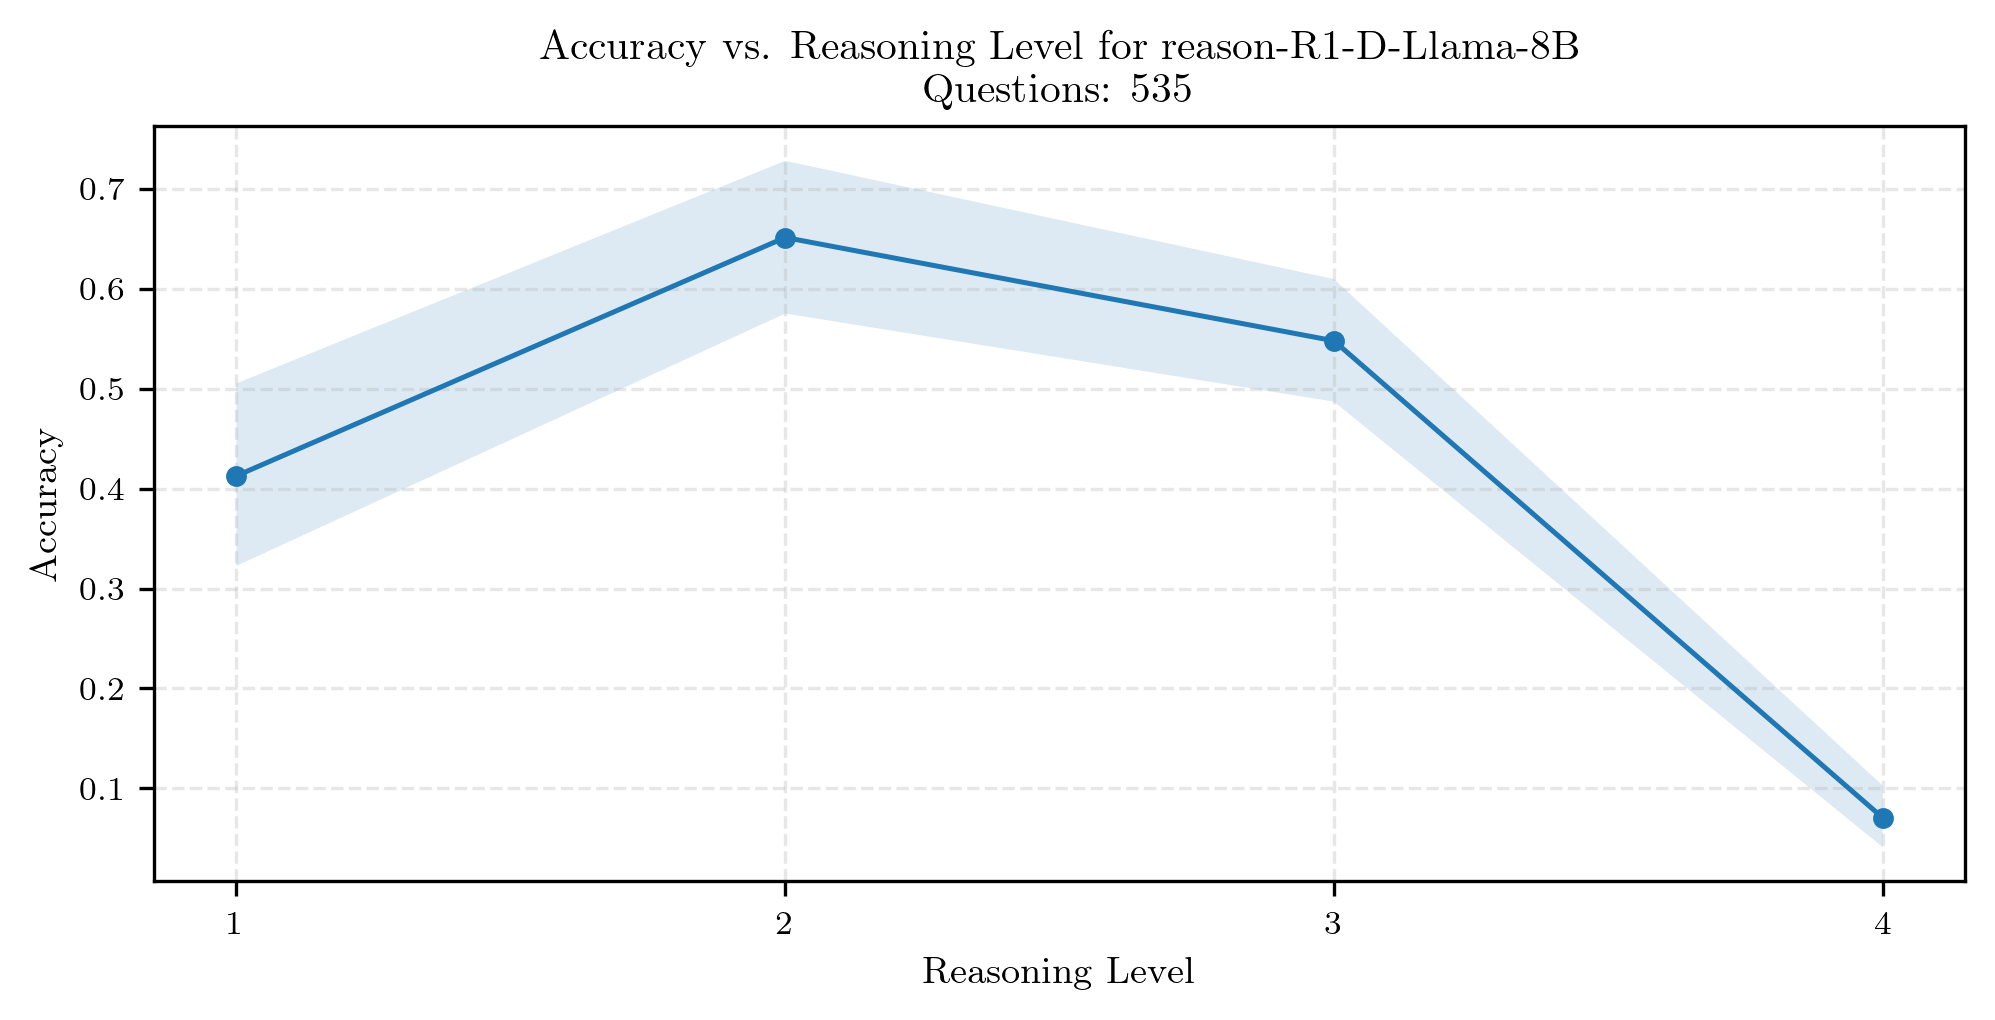

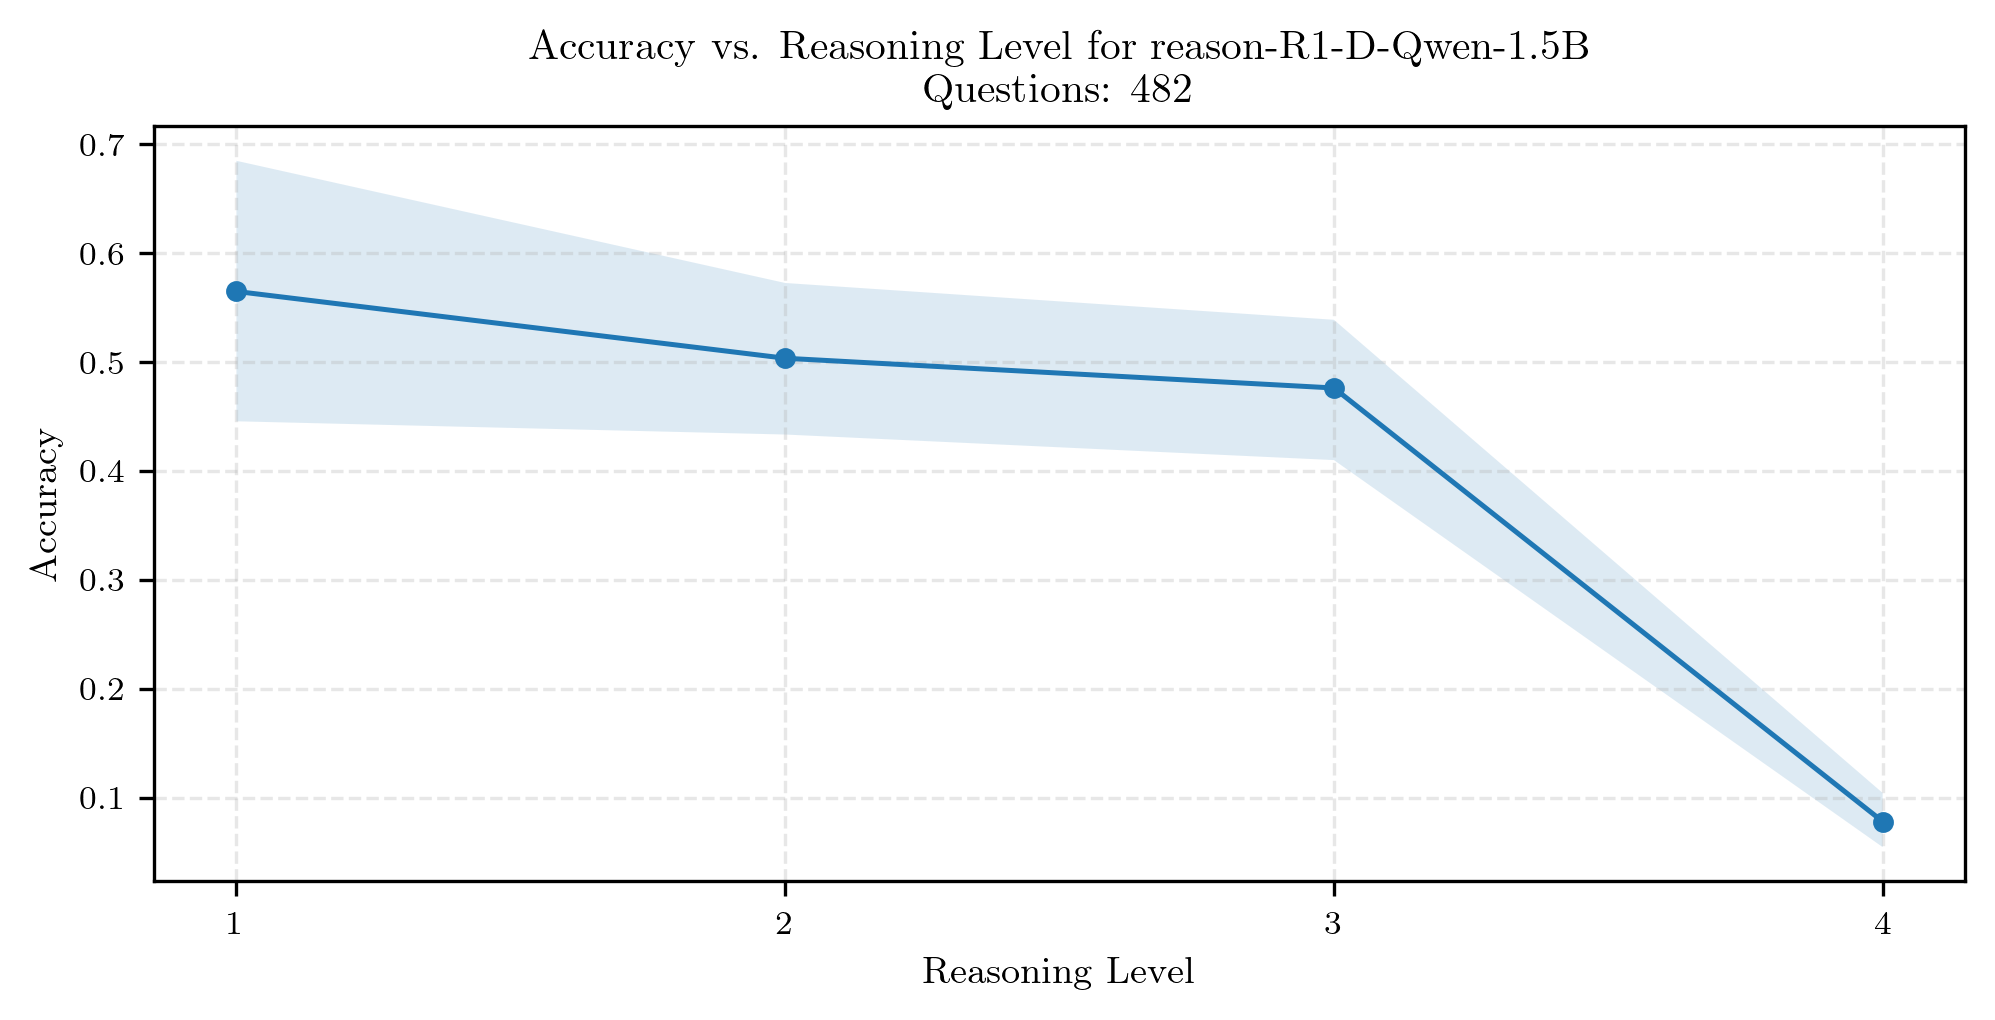

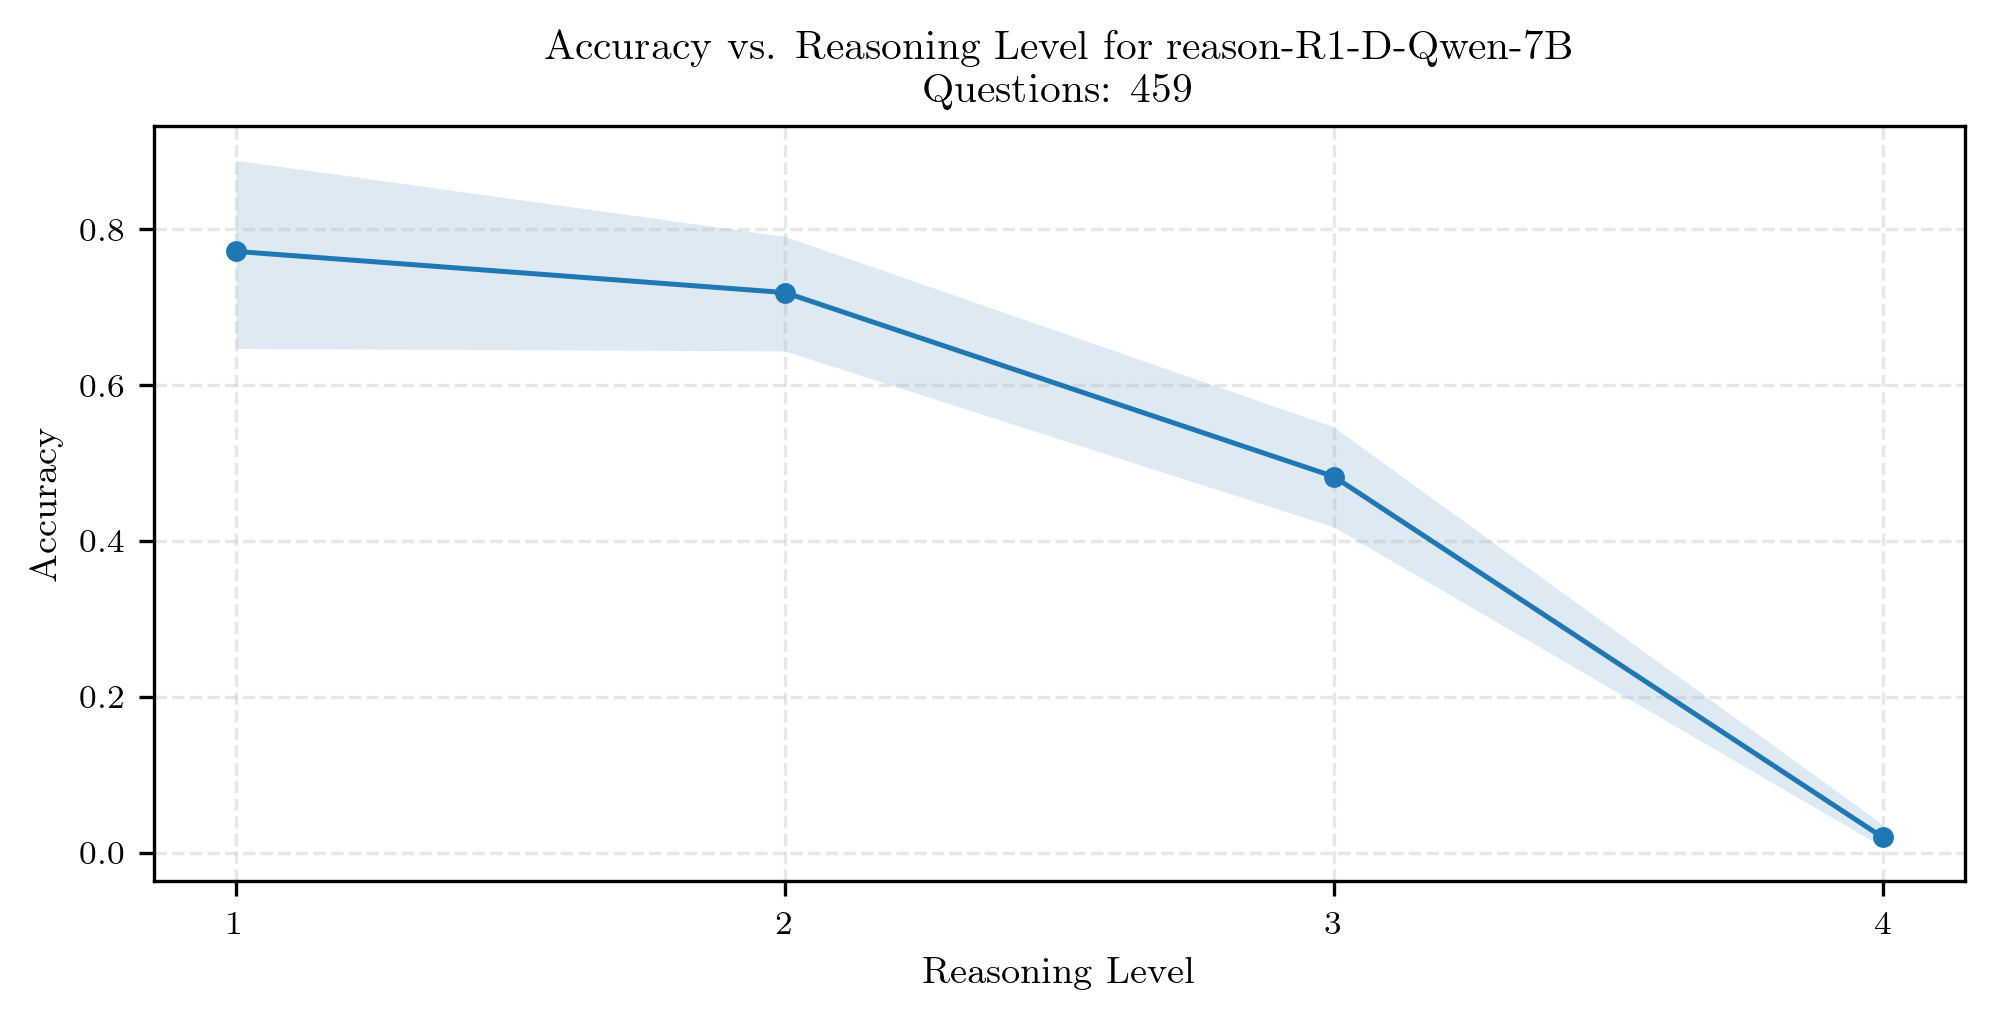

In [9]:
reasoning_accuracy = {}
reasoning_tokens = {}

for model_name in reasoning_models:
    means, stds, tokens, token_stds = reasoning_accuracy_curve_second_custom(
        results[model_name], qs=(0.0, 0.10, 0.50, 0.75, 1.0)
    )

    plot_reasoning_curve_2(
        means,
        stds,
        title="Accuracy vs. Reasoning Level for " + model_name.split("--")[0],
        num_questions=len(results[model_name]["correct"]),
    )

    reasoning_accuracy[model_name] = means
    reasoning_tokens[model_name] = tokens

# Analysis

In [10]:
accuracy = {}
tokens = {}

for model_name in reasoning_models:
    accuracy[model_name] = reasoning_accuracy[model_name]
    tokens[model_name] = reasoning_tokens[model_name]